# **5.5. ARIMA**  
Objetivo: Realizar un forecast con ARIMA.

## Importación de librerías a utilizar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

## Definición de funciones para la creación manual de una serie temporal sintética.

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """Esta función grafica una serie temporal situando:
        - En el eje x el primer argumento (tiempo).
        - En el eje y el segundo argumento (series)."""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    """Esta función crea una tendencia a partir de una pendiente,
    cuyo resultado es una línea recta."""
    return slope * time

def seasonal_pattern(season_time):
    """Esta función genera un patrón estacional arbitrario."""
    return np.where(
        season_time < 0.1,
        np.cos(season_time * 7 * np.pi),
        1 / np.exp(5 * season_time)
    )

def seasonality(time, period, amplitude=1, phase=0):
    """Esta función aplica un mismo patrón cada cierto período
    de tiempo (amplitude)."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Esta función genera un ruido aleatorio."""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Creación serie temporal sintética.

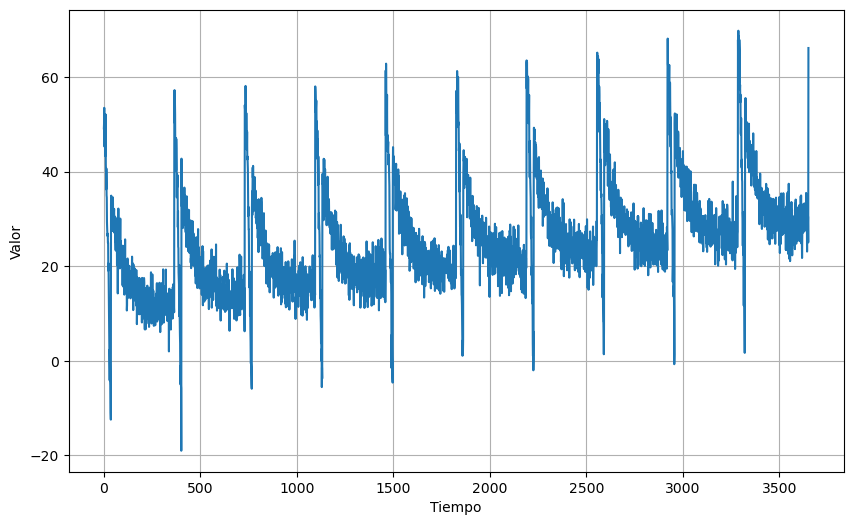

In [4]:
# Definición del lag y la duración de la serie: frecuencia diaria durante 10 años.
time = np.arange(10 * 365 + 1, dtype="float32")

# Variables de la serie:
baseline = 10     # Valor de base.
amplitude = 40    # Amplitud de la estacionalidad, esta se repite cada 40 puntos. 
slope = 0.005     # Pendiente de la tendencia.
noise_level = 3   # Nivel de ruido.

# Creación de la serie:
# 1.- Generamos la tendencia.
series = trend(time, slope)
# 2.- Añadimos la estacionalidad.
series += baseline + seasonality(time, period=365, amplitude=amplitude)
# 3.- Añadimos el ruido.
series += noise(time, noise_level, seed=51)

# Representamos gráficamente la serie:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Comprobación estacionariedad datos.

### Método 1: Cálculo de la media y varianza.

Partimos por la mitad la serie generando dos variables y calculamos la media y varianza de cada parte:

In [5]:
split = round(len(series) / 2)
split

1826

In [6]:
X_1, X_2 = series[0:split], series[split:]
mean_1, mean_2 = X_1.mean(), X_2.mean()
var_1, var_2 = X_1.var(), X_2.var()

In [7]:
print("Chequeo de estacionariedad\n")
print("Diferencias entre media y varianza a lo largo de la serie:")
print(f"Media en 1ª mitad = {mean_1}, media en 2ª mitad = {mean_2}")
print(f"Varianza en 1ª mitad = {var_1}, varianza en 2ª mitad = {var_2}")

Chequeo de estacionariedad

Diferencias entre media y varianza a lo largo de la serie:
Media en 1ª mitad = 20.85043716430664, media en 2ª mitad = 29.994253158569336
Varianza en 1ª mitad = 92.75602722167969, varianza en 2ª mitad = 92.68231964111328


Graficamos la media, varianza a lo largo de la serie y un histograma con la distribución de valores.

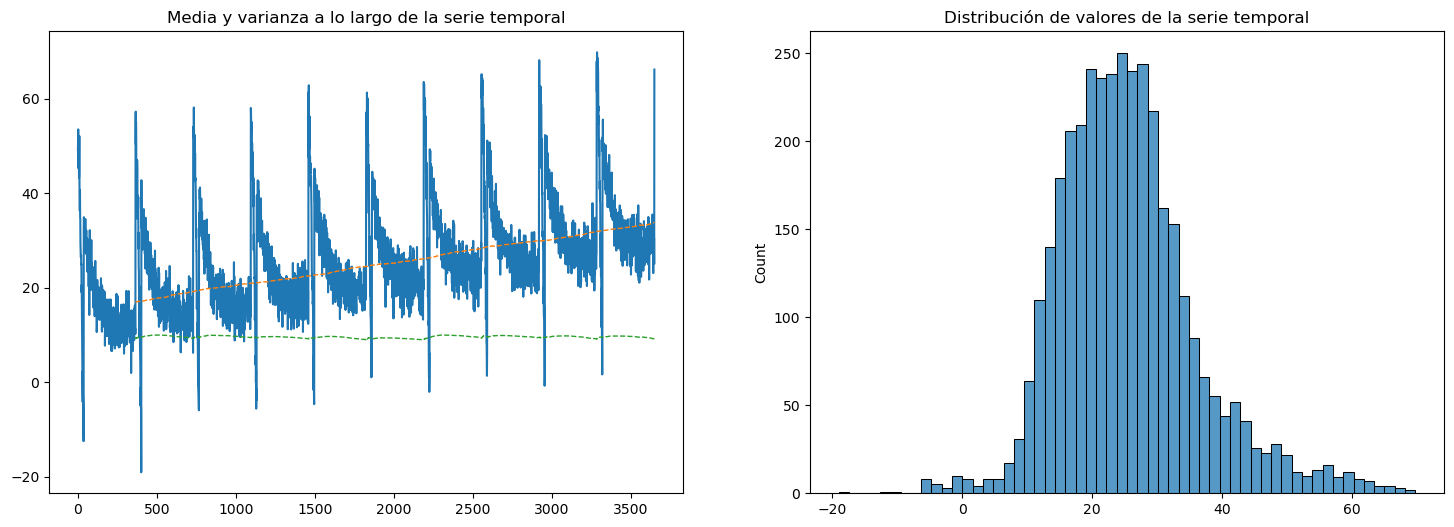

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(series, label="series")

df_series = pd.DataFrame(series, columns=["value"])
mean_12 = df_series["value"].rolling(365).mean()
std_12 = df_series["value"].rolling(365).std()
ax[0].plot(mean_12, "--", linewidth=1, label="mean")
ax[0].plot(std_12, "--", linewidth=1, label="std")
ax[0].set_title("Media y varianza a lo largo de la serie temporal")

sns.histplot(series, ax=ax[1])
ax[1].set_title("Distribución de valores de la serie temporal")

plt.show()

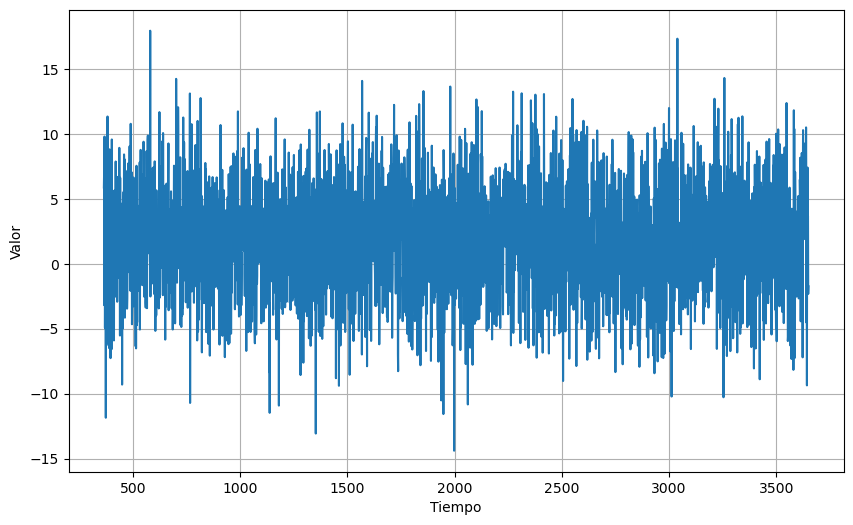

In [9]:
# A partir del primer día del segundo año, calculamos la diferencia de cada día con su homólogo en la estación previa..
diff_series = (series[365:] - series[:-365]) # Pandas ofrece el método diff() para aplicar diferencias.
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

Chequeo de estacionariedad

Diferencias entre media y varianza a lo largo de la serie:
Media en 1ª mitad = 1.824644923210144, media en 2ª mitad = 1.8918979167938232
Varianza en 1ª mitad = 17.52820587158203, varianza en 2ª mitad = 17.968950271606445


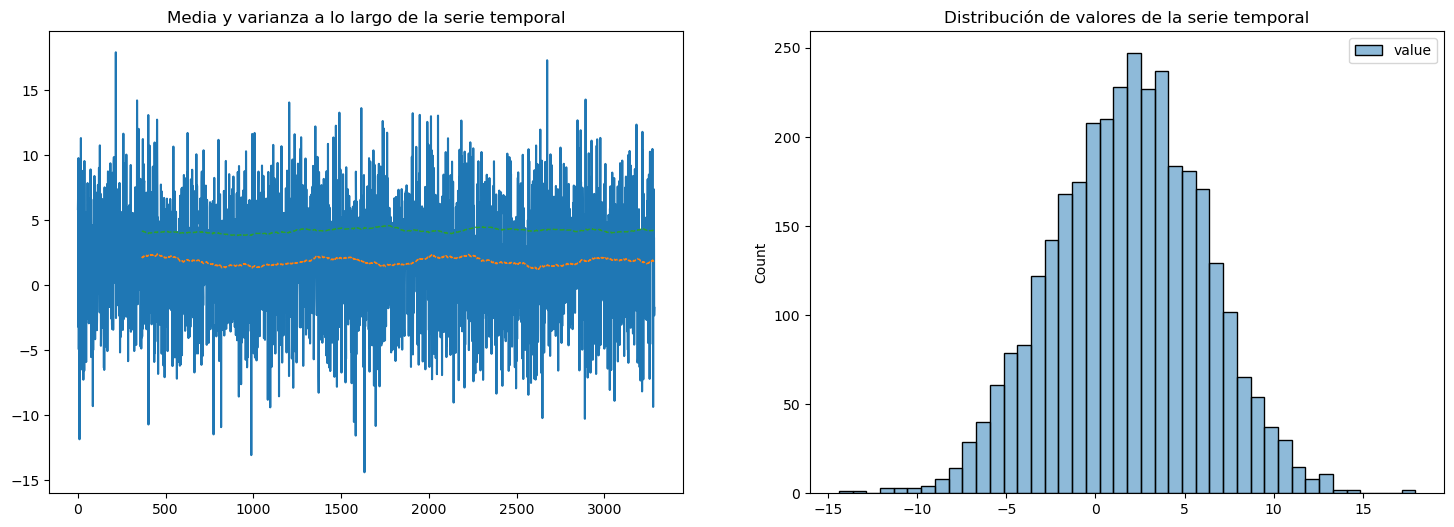

In [10]:
split = round(len(diff_series)/2)

X_1, X_2 = diff_series[0:split], diff_series[split:]
mean_1, mean_2 = X_1.mean(), X_2.mean()
var_1, var_2 = X_1.var(), X_2.var()

print("Chequeo de estacionariedad\n")
print("Diferencias entre media y varianza a lo largo de la serie:")
print(f"Media en 1ª mitad = {mean_1}, media en 2ª mitad = {mean_2}")
print(f"Varianza en 1ª mitad = {var_1}, varianza en 2ª mitad = {var_2}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(diff_series, label="series")

df_series = pd.DataFrame(diff_series, columns=["value"])
mean_12 = df_series["value"].rolling(365).mean()
std_12 = df_series["value"].rolling(365).std()
ax[0].plot(mean_12, "--", linewidth=1, label="mean")
ax[0].plot(std_12, "--", linewidth=1, label="std")
ax[0].set_title("Media y varianza a lo largo de la serie temporal")

sns.histplot(df_series, ax=ax[1])
ax[1].set_title("Distribución de valores de la serie temporal")

plt.show()

### Método 2: Realización del Augmented Dickey Fuller Test.

Podemos invocar la función adfuller() importada al inicio del notebook y pasarle como argumento el array con los valores de nuestra serie.

In [11]:
result = adfuller(series)

In [12]:
p_value = result[1]
print(f"p-value: {p_value}", "=", format(p_value, 'f'))

p-value: 1.547729584542546e-05 = 0.000015


Se toma como hipótesis que la serie no será estacionaria. Se refuta la hipótesis si el valor p_value no es significante, es decir, si este valor es inferior a 0.05 (o menos de 0.01). Dado que el valor es menor que este nivel de significanza entonces podríamos decir que la serie es estacionaria.

# Forecast con ARIMA

### Encontrar valores de q y p a través de los correlogramas:  ACF y PACF.

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


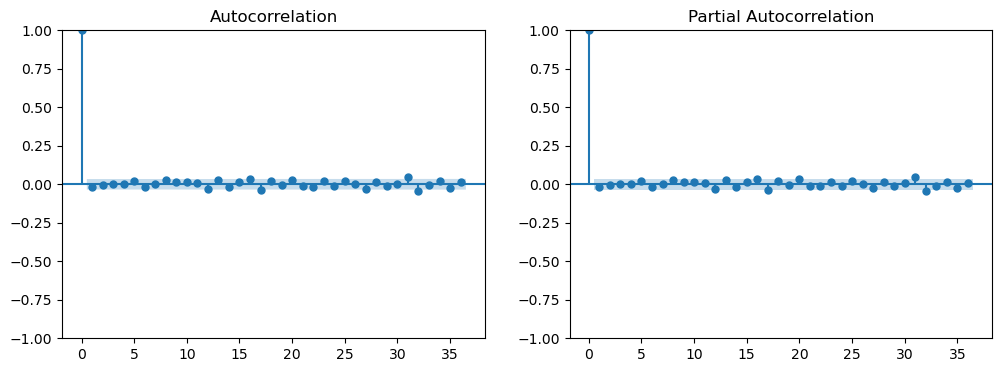

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plot_acf(diff_series, ax=ax[0]) # ACF - Autocorrelación
plot_pacf(diff_series, ax=ax[1]) # PACF - Partial Autocorrelación
plt.show()

Parámetros de nuestro modelo ARIMA: p=1, d=1, q=1

In [14]:
model = ARIMA(series, order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3651
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11086.171
Date:                Tue, 09 May 2023   AIC                          22178.343
Time:                        18:43:55   BIC                          22196.950
Sample:                             0   HQIC                         22184.970
                               - 3651                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0116      0.037      0.315      0.753      -0.061       0.084
ma.L1         -0.3827      0.036    -10.512      0.000      -0.454      -0.311
sigma2        25.4487      0.166    153.002      0.0

Una buena explicación sobre la interpretabilidad del summary se puede encontrar en: https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c

In [15]:
# 9 años de train y 1 de test
SPLIT_TIME = 3285

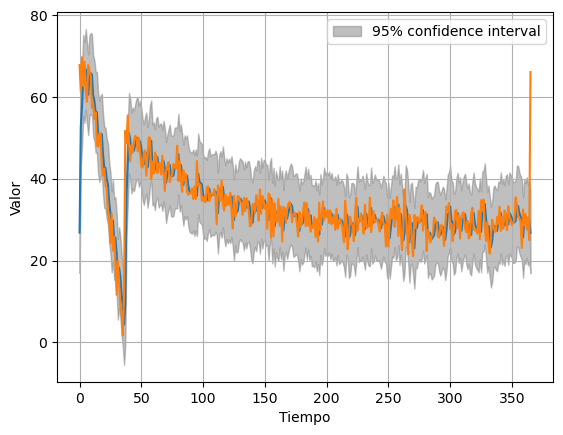

In [16]:
y_pred = results.predict(start=SPLIT_TIME, end=len(series)-1, dynamic=False)   #dynamic=False (realizamos la predicción del siguiente lag)
plot_predict(results, start=SPLIT_TIME, end=len(series)-1, dynamic=False)   #dynamic=False (realizamos la predicción del siguiente lag)
time_test = time[0:366]
y_test = series[SPLIT_TIME:]
plot_series(time_test, y_test)
plt.show()

In [17]:
y_pred

array([26.83373302, 52.6259131 , 57.95442995, 65.34694172, 63.60522209,
       66.80043451, 63.45257135, 60.58128645, 65.17734471, 65.84492847,
       65.48503739, 60.36583721, 59.11972162, 56.3120841 , 56.29907522,
       51.21562697, 49.12478602, 50.39552116, 50.92688492, 45.92669706,
       42.75627792, 42.63485544, 39.94677011, 38.64927435, 34.12593338,
       31.61758343, 27.03643894, 29.82034387, 25.14345171, 25.63444809,
       21.77849088, 15.44002285, 18.28176427, 16.07764055, 11.67095168,
        8.83868316,  4.34955223,  9.22300559, 35.94572701, 43.83146048,
       51.1353957 , 49.67068485, 46.29575713, 47.54058231, 46.85818067,
       48.34768205, 49.68249907, 50.04177104, 47.94261482, 49.18126619,
       47.54667357, 44.76981114, 43.51531068, 45.27897836, 46.32960907,
       42.81490141, 44.73765935, 48.1249169 , 49.31266485, 43.36297382,
       43.92933904, 42.25028586, 44.9215027 , 45.31272334, 42.85528857,
       43.47038121, 43.67520335, 42.02081035, 44.31945986, 42.51

In [18]:
y_test

array([67.85431  , 61.379692 , 69.77225  , 62.65917  , 68.668365 ,
       61.51158  , 58.851208 , 67.8574   , 66.288315 , 65.28086  ,
       57.341393 , 58.328606 , 54.640785 , 56.26055  , 48.215336 ,
       47.83567  , 51.121548 , 51.253826 , 42.98228  , 40.83117  ,
       42.527676 , 38.35864  , 37.85435  , 31.442183 , 30.087952 ,
       24.30502  , 31.412622 , 22.413157 , 25.873775 , 19.507631 ,
       11.657982 , 19.888779 , 14.806719 ,  9.047248 ,  7.1190257,
        1.6689196, 12.049197 , 51.766113 , 48.77658  , 55.536488 ,
       48.887638 , 44.289867 , 48.23809  , 46.46839  , 49.219395 ,
       50.48622  , 50.2686   , 46.708157 , 49.88937  , 46.595222 ,
       43.113712 , 42.744503 , 46.305435 , 46.9685   , 40.752777 ,
       45.834156 , 50.143867 , 50.05078  , 39.865875 , 44.198986 ,
       41.264507 , 46.479507 , 45.572327 , 41.410027 , 43.806652 ,
       43.80227  , 41.04695  , 45.657845 , 41.480305 , 37.045002 ,
       42.017097 , 42.97033  , 44.10855  , 39.22117  , 40.5233

### Evaluación

La predicción la realiza sobre la diferencia, así que le sumamos el valor año anterior.

In [19]:
print("Error MSE: ", mean_squared_error(y_test, y_pred))
print("Error MAE: ", mean_absolute_error(y_test, y_pred))

Error MSE:  29.32864898435939
Error MAE:  3.4703354933504444
